In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xlrd

### Load datasets

In [2]:
exp_file = r'C:\data\OneDrive\WSP O365\chattanooga-modeling - RTP TDM Update\Deliverables\Task 3_Model Validation\survey_expansion\01052016_Data_Cleaning_19.xlsx'
taz_file = r'C:\data\OneDrive\WSP O365\chattanooga-modeling - RTP TDM Update\Data\TAZ.shp'

dir_path = os.path.join('..', '..', 'Data', 'survey', '2015 on-board survey')
survey_geo_file = 'survey_geocoded_rev.csv'
survey_geo_export = 'survey_geocoded_{}.shp'
survey_expanded_export = 'survey_expanded.csv'

d_types = {'RespondentID': str}

##### Function for Temp fix of NA ID with Route

In [3]:
def fix_with_route(df):
    df.loc[df['RespondentID'].isna(), 'RespondentID'] = df['Route '].apply(lambda x: str(x).split('-')[0])

##### Load Survey Expansion

In [4]:
survey_exp = pd.read_excel(exp_file, sheet_name='Sheet2', engine='openpyxl')
survey_exp = survey_exp[['RespondentID', 'Route ', 'linked trip weight', 'unlinked weight (boarding weight)']].copy()

#Fix NA
fix_with_route(survey_exp)

##### Load SED datasets

In [5]:
taz = gpd.read_file(taz_file)
taz = taz[['TAZ_ID', 'DISTRICT', 'geometry']].copy()

epsg:2274


<AxesSubplot:>

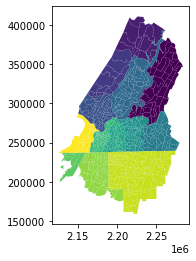

In [6]:
print(taz.crs)
taz.plot(column='DISTRICT')

##### Load Survey Geocode Results

In [7]:
survey_geo = pd.read_csv(os.path.join(dir_path, survey_geo_file))
#Fix NA
fix_with_route(survey_geo)

# print(list(survey_geo))
survey_geo = survey_geo[[
    'RespondentID',
    'lat_left',
    'lng_left',
    'lat_dest',
    'lng_dest',
    'Geocode_result_left',
    'Geocode_result_dest',
    'Left_Add_EDIT',
    'lat_left_EDIT',
    'lng_left_EDIT',
    'Dest_Add_EDIT',
    'lat_dest_EDIT',
    'lng_dest_EDIT'
]].copy()

##### Consolidate Geocode results from Automated and Manual process

In [8]:
cols = ['{}_{}'.format(c,p) for p in ['left', 'dest'] for c in ['lat', 'lng']]

for col in cols:
    survey_geo[col] = survey_geo['{}_EDIT'.format(col)].combine_first(survey_geo[col])
    
survey_geo.loc[survey_geo['Left_Add_EDIT'].notna(), 'Geocode_result_left'] = 'manual'
survey_geo.loc[survey_geo['Dest_Add_EDIT'].notna(), 'Geocode_result_dest'] = 'manual'

### Overlay with SED, for 'Left' and 'Dest' locations

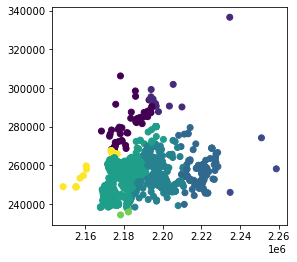

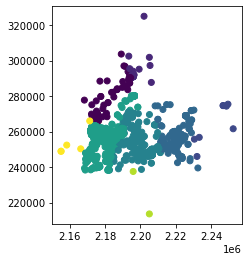

In [16]:
### Use only records with accepted Geocode results
geo_pass = ['pass', 'manual']
surveys = {}

for l in ['left', 'dest']:
    lat = 'lat_{}'.format(l)
    lng = 'lng_{}'.format(l)
    Geocode_result = 'Geocode_result_{}'.format(l)
    geo_cols = ['RespondentID', lat, lng, Geocode_result]
    taz_columns = {col: '{}_{}'.format(col, l.upper()) for col in ['TAZ_ID', 'DISTRICT']}
    
    surveys[l] = survey_geo[survey_geo[Geocode_result].isin(geo_pass)]
    
    surveys[l] = gpd.GeoDataFrame(surveys[l][geo_cols],
                              geometry=[Point(xy) for xy in zip(surveys[l][lng], surveys[l][lat])],
                              crs='epsg:4326'
                             ).to_crs(epsg=2274)
    
    surveys[l] = gpd.sjoin(surveys[l], taz, how='inner')
    surveys[l] = surveys[l].rename(columns = taz_columns)
    
    surveys[l].plot(column='DISTRICT_{}'.format(l.upper()))
    
#     # To Shapefile
#     surveys[l] = surveys[l][['RespondentID']+[*taz_columns.values()]+['geometry']]
#     surveys[l].to_file(os.path.join(dir_path, survey_geo_export.format(l)))
    
    surveys[l] = surveys[l][['RespondentID']+[*taz_columns.values()]]

### Join to Expansion Values table

In [10]:
for srv in surveys.values():
    survey_exp = pd.merge(survey_exp, srv, how='inner', on='RespondentID')

### Export to .csv

In [11]:
survey_exp.to_csv(os.path.join(dir_path, survey_expanded_export), index=False)
print('Expanded Survey with O/D exported to: {}'.format(os.path.join(dir_path, survey_expanded_export)))

survey_exp.head()

Expanded Survey with O/D exported to: ..\..\Data\survey\2015 on-board survey\survey_expanded.csv


,RespondentID,Route,linked trip weight,unlinked weight (boarding weight),TAZ_ID_LEFT,DISTRICT_LEFT,TAZ_ID_DEST,DISTRICT_DEST
0,4.19933e+09,10- East Chattanooga,3.184783,6.369566,897,8.0,410,9.0
1,4.20607e+09,10- East Chattanooga,3.184783,3.184783,434,8.0,752,9.0
2,4.20963e+09,21- Golden Gateway,2.755814,8.267442,731,9.0,752,9.0
3,4.20971e+09,8- Eastdale,1.421053,4.263159,336,8.0,472,7.0
4,4.21002e+09,1- Alton Park,2.488372,4.976744,272,9.0,272,9.0


### Explode rows

In [12]:
explode_col = 'linked trip weight'

for i, row in survey_exp.iterrows():
    survey_exp = survey_exp.append([row]*(round(row[explode_col])-1))

In [39]:
print('Expanded Trips: {:,}'.format(len(survey_exp)))

survey_exp[survey_exp['RespondentID']==survey_exp['RespondentID'].sample(1).values[0]]
# survey_exp.head()

Expanded Trips: 3,114


,RespondentID,Route,linked trip weight,unlinked weight (boarding weight),TAZ_ID_LEFT,DISTRICT_LEFT,TAZ_ID_DEST,DISTRICT_DEST
963,4.26158e+09,9- East Lake,2.504202,2.504202,316,9.0,227,9.0
963,4.26158e+09,9- East Lake,2.504202,2.504202,316,9.0,227,9.0
963,4.26158e+09,9- East Lake,2.504202,2.504202,316,9.0,227,9.0
